# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [309]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [310]:
%matplotlib inline

In [311]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [312]:
import warnings
warnings.filterwarnings('ignore')

In [313]:
from sklearn.decomposition import PCA

In [314]:
from sklearn.preprocessing import StandardScaler

In [315]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/simplesc')
import scme, utils

In [316]:
data_path = '/data/parameter_estimation/interferon_data/20191218/'

### Perform some basic filtering

In [317]:
adata = sc.read(data_path + 'interferon.raw.h5ad')
adata = adata[:, adata.var.index.map(lambda x: x[:2] != 'HB')]

In [318]:
adata.obs.cell.value_counts()

CD4 T cells          10373
CD14+ Monocytes      5355 
B cells              2570 
CD8 T cells          2039 
NK cells             1991 
FCGR3A+ Monocytes    1592 
Dendritic cells      432  
Megakaryocytes       208  
Name: cell, dtype: int64

In [319]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

Trying to set attribute `.obs` of view, making a copy.


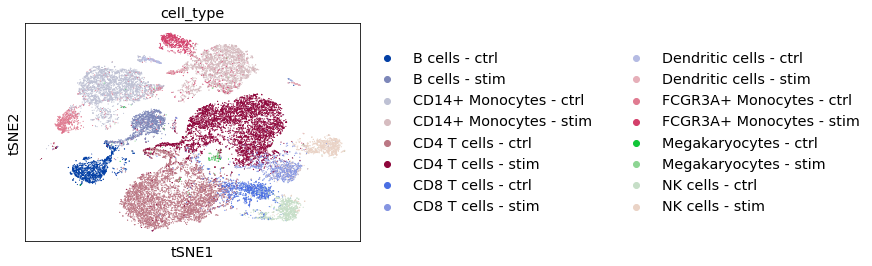

In [320]:
sc.pl.tsne(adata, color='cell_type')

In [321]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [322]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 1880


### Useful functions

In [323]:
def density_scatterplot(a,b, s=1, cmap='Reds', kde=None):
    # Calculate the point density
    condition = np.isfinite(a) & np.isfinite(b)
    x = a[condition]
    y = b[condition]
    xy = np.vstack([x,y])
    z = stats.gaussian_kde(xy, bw_method=kde)(xy)
    print(z)
    plt.scatter(x, y, c=z, s=s, edgecolor='', cmap=cmap)
    

def robust_correlation(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    return stats.pearsonr(x,y)

def robust_linregress(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    print(x.min())
    
    return stats.linregress(x,y)

def robust_hist(x, **kwargs):
    
    condition = np.isfinite(x)
    plt.hist(x[condition], **kwargs)

### Differential expression + variability plot

In [324]:
adata.obs.cell.drop_duplicates()

index
AAACATACATTTCC-1    CD14+ Monocytes  
AAACATACCATGCA-1    CD4 T cells      
AAACATACCTGGTA-1    Dendritic cells  
AAACATACGTGTAC-1    NK cells         
AAACATTGAGTGTC-1    CD8 T cells      
AAACATTGCTCGAA-1    B cells          
AAACGCACAGTACC-1    Megakaryocytes   
AAACGCACATTCGG-1    FCGR3A+ Monocytes
Name: cell, dtype: category
Categories (8, object): [B cells, CD4 T cells, CD8 T cells, CD14+ Monocytes, Dendritic cells, FCGR3A+ Monocytes, Megakaryocytes, NK cells]

In [329]:
with open(data_path + 'stim_effect_1d.pkl', 'rb') as f:
    stim_delta_dict = pkl.load(f)

In [352]:
def plot_de_dv(ct):
    
    de_diff = stim_delta_dict[(ct + ' - ctrl', ct + ' - stim')]['de_diff']
    dv_diff = stim_delta_dict[(ct + ' - ctrl', ct + ' - stim')]['dv_diff']
    de_fdr = stim_delta_dict[(ct + ' - ctrl', ct + ' - stim')]['de_fdr']
    dv_fdr = stim_delta_dict[(ct + ' - ctrl', ct + ' - stim')]['dv_fdr']
    
    sig = (de_fdr < 0.1) & (dv_fdr < 0.1)
    
    lower_right = adata.var.index[(de_diff > 0) & (dv_diff < 0) & sig]
    upper_right = adata.var.index[(de_diff > 0) & (dv_diff > 0) & sig]
    lower_left = adata.var.index[(de_diff < 0) & (dv_diff < 0) & sig]
    upper_left = adata.var.index[(de_diff < 0) & (dv_diff > 0) & sig]
    
    plt.figure(figsize=(6, 4.5));
    plt.scatter(de_diff[sig], dv_diff[sig], s=40, color='g')
    plt.scatter(de_diff[~sig], dv_diff[~sig], s=1, color='grey')
    plt.plot([0, 0], [-4, 2.5], '--', lw=5, color='k')
    plt.plot([-3, 5], [0, 0], '--', lw=5, color='k')

    plt.xlabel('Mean Log-FC');
    plt.ylabel('Residual variance Log-FC')
    plt.xlim(-3, 6); plt.ylim(-4, 4)
    plt.title(ct)
    
    print('lower right', lower_right.tolist())
    print('upper right', upper_right.tolist())
    print('lower left', lower_left.tolist())
    print('upper left', upper_left.tolist())
    #plt.savefig(data_path + 'figures/cd4_2d_changes.pdf', bbox_inches='tight')

lower right ['HES4', 'IFI6', 'IFI44L', 'CHI3L2', 'BTN3A3', 'LY6E', 'TLE4', 'FAS', 'IFIT1', 'OASL', 'PHF11', 'CCL7']
upper right ['TNFSF10', 'ANXA2R', 'SMC1A', 'PRF1']
lower left ['TNFRSF4', 'SBDS', 'NUCB2', 'GABARAPL1', 'LINC00936', 'GPR18', 'APP']
upper left ['CD52', 'FAM159A', 'S100A8', 'CXCR4', 'FAM162A', 'H1FX', 'OSGEP', 'CCPG1', 'TMEM204', 'YPEL3']


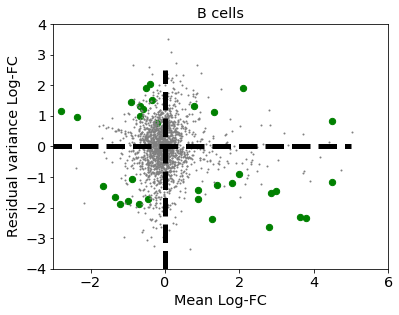

In [353]:
plot_de_dv('B cells')
plt.savefig('B_de_dv.pdf', bbox='tight')

lower right ['IFI6', 'MNDA', 'RSAD2', 'UBXN2A', 'IL1RN', 'BAK1', 'IDO1', 'IFIT3', 'IFIT1', 'IFIT5', 'CCL7', 'ZBP1', 'PRKD2']
upper right ['IFI44L', 'ZC3HAV1', 'CUL2', 'PRF1', 'SOCS3']
lower left ['TNFRSF18', 'TNFRSF4', 'MITD1', 'SMIM20', 'MRPL2', 'FBXO9', 'EHD1', 'LYRM5', 'LINC00667']
upper left ['S1PR1', 'CXCR4', 'STAT6', 'ACTR6', 'RNF126', 'POLDIP3']


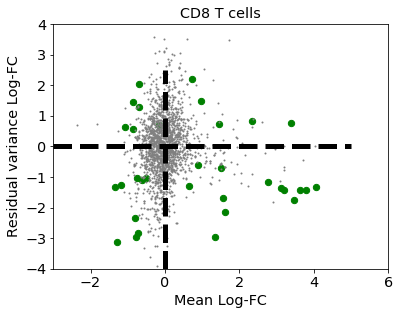

In [354]:
plot_de_dv('CD8 T cells')
plt.savefig('cd8_de_dv.pdf', bbox='tight')

lower right ['IFI6', 'IFI44L', 'IFI44', 'CMPK2', 'EIF2AK2', 'ARHGAP25', 'GPR155', 'C2orf47', 'TRAT1', 'CYCS', 'GIMAP4', 'LY6E', 'IFIT3', 'IFIT1', 'TRIM22', 'PARP11', 'SLC38A2', 'OASL', 'LGALS2']
upper right ['TNFSF10', 'RPF2', 'ZC3HAV1', 'FABP5', 'HSPA5', 'MAP3K8', 'PRF1', 'IFI27', 'CCR7']
lower left ['MIS18BP1', 'UQCRC2', 'DLGAP1-AS1', 'CHMP1B', 'BABAM1']
upper left ['CD52', 'METTL21A', 'VCAN', 'CLEC5A', 'C10orf54', 'THBS1', 'EMP3', 'IFNAR2']


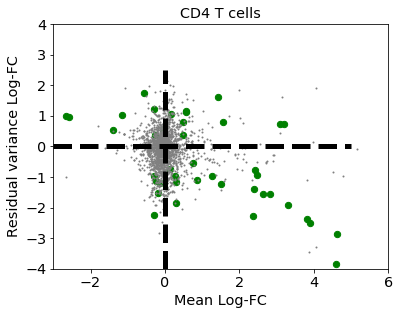

In [355]:
plot_de_dv('CD4 T cells')
plt.savefig('cd4_de_dv.pdf', bbox='tight')

lower right ['IFI6', 'IFI44L', 'CHI3L2', 'HPSE', 'DAPP1', 'DERL1', 'LY6E', 'IFIT2', 'IFIT3', 'C3AR1', 'HSP90B1', 'PMAIP1', 'XBP1']
upper right ['GBP1', 'GZMK', 'HLA-DRB1', 'TMEM140', 'FCN1', 'LAG3', 'GZMB', 'SDF2L1']
lower left ['MAEA', 'EEF1E1', 'TACC1']
upper left ['ZNF593', 'S100A4', 'PDCD6IP', 'DEF6', 'CXCR3', 'SNHG7', 'TFAM', 'PNMA1', 'GRAMD1A', 'HSPBP1']


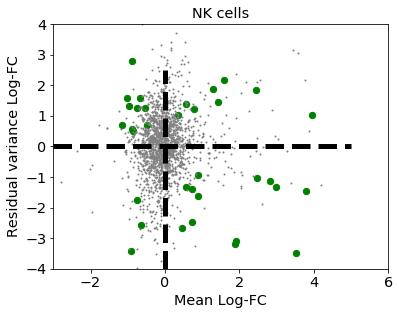

In [356]:
plot_de_dv('NK cells')
plt.savefig('nk_de_dv.pdf', bbox='tight')

lower right ['IFI6', 'IFI44L', 'IFI44', 'GBP1', 'GBP4', 'CKS1B', 'MNDA', 'SLAMF7', 'RSAD2', 'EIF2AK2', 'IL1RN', 'TNFSF10', 'LAMP3', 'CD38', 'ARAP2', 'CXCL11', 'PPM1K', 'ANXA5', 'IL7R', 'IRF1', 'MAT2B', 'HSPB1', 'TMEM140', 'SLC38A5', 'SEPT6', 'IDO1', 'FCN1', 'IFIT3', 'IFIT1', 'TRIM22', 'RAD9A', 'OASL', 'EPSTI1', 'PHF11', 'TNFSF13B', 'IGSF6', 'MT2A', 'CNP', 'TCF4', 'CFD', 'GADD45B', 'CTD-2521M24.9', 'ZNF766', 'APOBEC3A']
upper right ['FCER1G', 'SERPINB1', 'GIMAP1', 'CLEC2D', 'MED21', 'UBL3', 'FAM177A1', 'CCR7', 'LPIN2', 'LGALS2']
lower left ['STMN1', 'VPS72', 'SCAMP3', 'TUBA4A', 'TRNT1', 'KIAA1143', 'IFRD2', 'RIOK1', 'NUPL2', 'AQP3', 'AKR1C3', 'CD3E', 'CD27', 'PAPOLA', 'COPS2', 'PDCD7', 'CD79B', 'C19orf59']
upper left ['MRTO4', 'LDLRAP1', 'HMGN2', 'RABGGTB', 'C1orf162', 'RSBN1', 'LMNA', 'LINC00116', 'ACSL3', 'MRPS25', 'CCDC12', 'SMARCC1', 'SRP72', 'IL8', 'SLC30A5', 'CD14', 'EEF1E1', 'PAK1IP1', 'IER3', 'LSM2', 'DEF6', 'C6orf203', 'CLEC5A', 'EBP', 'PRKDC', 'GPAA1', 'ANP32B', 'PTRH1', 'PTGE

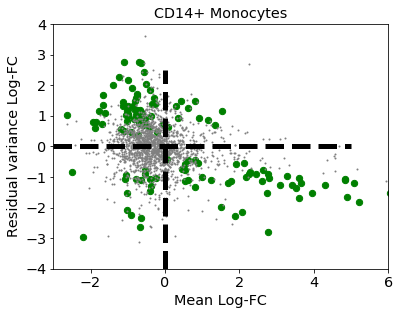

In [357]:
plot_de_dv('CD14+ Monocytes')
plt.savefig('cM_de_dv.pdf', bbox='tight')

lower right ['IFI6', 'GBP4', 'GBP5', 'MNDA', 'KIAA0040', 'EIF2AK2', 'ARID5A', 'IL1RN', 'TNFSF10', 'LAMP3', 'CXCL11', 'FAM26F', 'PPP3CC', 'IFIT1', 'IFIT5', 'TRIM22', 'CDK17', 'N4BP2L1', 'TNFSF13B', 'MT2A', 'ZNF766']
upper right ['C1orf174', 'CD38', 'IGFBP7', 'MRPL18', 'DEFB1', 'CD59', 'PLA2G16', 'CCDC85B', 'CTSC', 'CLEC2B', 'N4BP1', 'IGLL5', 'APOBEC3B']
lower left ['S100A12', 'DUSP10', 'SRP72', 'R3HCC1', 'BCCIP', 'TMEM256', 'SIRT2']
upper left ['MARCKSL1', 'THEM4', 'DHX9', 'PPP2R5A', 'XPC', 'GPX1', 'GLT8D1', 'POLR2B', 'IL8', 'SLC30A5', 'ACAT2', 'GALNT11', 'PCM1', 'C8orf33', 'BAD', 'ARHGAP9', 'FOS', 'MOAP1', 'VRK1', 'RAB27A', 'C16orf91', 'PGP', 'THOC6', 'ELP2', 'RNF126', 'WDR18', 'IL27RA', 'TIMM50', 'TOMM40', 'SNRNP70', 'DRG1', 'LGALS1', 'TOMM22', 'TTC3']


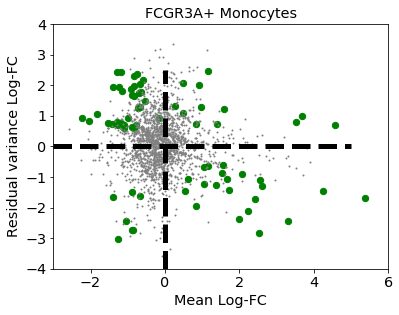

In [358]:
plot_de_dv('FCGR3A+ Monocytes')
plt.savefig('ncM_de_dv.pdf', bbox='tight')